## Setup

In [1]:
import os
import re
import pandas as pd
from string import printable
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

plt.style.use('fivethirtyeight')

In [2]:
ROOT_DIR = os.path.join('/notebooks/horoscope')
DATA_DIR = os.path.join(ROOT_DIR, 'data')

## Read data

In [103]:
df = pd.read_csv(os.path.join(DATA_DIR, 'horoscope_final.csv'),
                 names=['sign', 'category', 'date', 'text'])

In [104]:
df.shape

(21960, 4)

In [105]:
df.head(2)

,sign,category,date,text
0,aries,general,20200616,"Matters involving creativity, romance, and chi..."
1,aries,general,20200617,"There's a great day ahead of you, Aries. You'l..."


In [106]:
df.tail(2)

,sign,category,date,text
21958,pisces,birthday,20210615,"Your birthday brings you a fresh start, as you..."
21959,pisces,birthday,20210616,You will probably enjoy being the center of at...


## Simple Checks

In [107]:
df.nunique()

sign           12
category        5
date          366
text        12051
dtype: int64

In [109]:
df[df.duplicated(subset='text')].shape

(9909, 4)

In [110]:
df[df.duplicated(subset='text')]['category'].value_counts()

birthday    4026
wellness    3338
career      2233
love         311
general        1
Name: category, dtype: int64

In [111]:
# a duplicate example for category wellness
df[df.text == 'Coming full circle gives you a sense of accomplishment. Notice the things that you have accomplished, and you will inevitably see the pattern of ending up where you started but with greater self-awareness. Caring for yourself and your body is a way of constantly adapting to change while greeting "the new" optimistically. Our diet is our best prevention against disease, exercise our best weapon against depression, and good sleep our best way to feel truly centered. Concentrate on developing these skills to the fullest.']

,sign,category,date,text
1142,aries,wellness,20200730,Coming full circle gives you a sense of accomp...
1172,aries,wellness,20200829,Coming full circle gives you a sense of accomp...
17882,capricorn,wellness,20210426,Coming full circle gives you a sense of accomp...
17912,capricorn,wellness,20210526,Coming full circle gives you a sense of accomp...
19622,aquarius,wellness,20210126,Coming full circle gives you a sense of accomp...
19652,aquarius,wellness,20210225,Coming full circle gives you a sense of accomp...
21362,pisces,wellness,20201028,Coming full circle gives you a sense of accomp...
21392,pisces,wellness,20201127,Coming full circle gives you a sense of accomp...


Only 12051 unqiue texts?! 

- There are duplicates in texts for the category *birthday*. Those readings are unique for each date. Should fix that in the scraper.

- But it seems like all other categories have duplicates too! 

- From example above: The same exact piece of text is used for different `dates` and `signs`. Uhhhh...

Choosing to remove all duplicates in `text`

In [112]:
# drop duplicates in text
df_duplicated = df[df.duplicated(subset='text')]
df = df.drop(df_duplicated.index)

In [113]:
# different categories
df.category.value_counts()

general     4391
love        4081
career      2159
wellness    1054
birthday     366
Name: category, dtype: int64

In [114]:
# different signs
df.sign.value_counts()

aries          1811
gemini         1000
taurus         1000
cancer          999
leo             990
virgo           978
libra           971
scorpio         949
sagittarius     945
capricorn       867
aquarius        856
pisces          685
Name: sign, dtype: int64

In [115]:
# different dates
df.date.value_counts()

20210518    45
20210331    45
20210425    45
20210505    45
20210513    45
            ..
20201105    20
20201109    20
20201107    20
20201115    20
20200616    16
Name: date, Length: 366, dtype: int64

In [116]:
df.date.sort_values().values

array([20200616, 20200616, 20200616, ..., 20210616, 20210616, 20210616])

In [121]:
# sample texts
df.text.sample(3).values

array(["You might feel more energetic than you have in a long time, Aries. A powerful energy that increases your mental acuity and physical strength can really help you finish anything that's pending. If you managed to accomplish so much already that you have time to spare, it's fine to help others with their load. Be sure to put yours first, though.",
       "Are you doing something special for the people you live with tonight, Cancer? If so, you might be a little worried about what they might think of your skills as a chef, host, etc. Don't waste any time worrying. A good time will be had by all, including you. Everyone is likely to have a memorable evening. Just do your best, be your usual jovial self, and concentrate on having fun.",
       "Don't get too caught up in the mental aspect of your job. The danger here is that you will get so involved with the analytical thought process that you will forget that your true strengths lies in your intuition and sensitivity. Embrace these g

I notice that many texts have mentioned the `sign` name in the text too. Since my goal with the GPT2 model is to only generate texts based off `category`, it will be good to replace sign names in text with some generic word. Maybe like a *friend*.

In [122]:
# nulls?
df_nulls = df[(df.isnull().any(axis=1)) | (df.isna().any(axis=1))]
df_nulls.shape

(0, 4)

In [124]:
# samples
df_sample = df[['category', 'text']].sample(6)

for i in df_sample.values:
    print("| Category: ", i[0], '|')
    print("-"*20)
    print("Text: ", i[1])
    print("---"*40)

| Category:  career |
--------------------
Text:  Slow down your thought process so that you can fully absorb all the information that is coming your way. It is difficult to fully digest the scope of material that comes to your attention in a day unless you consciously slow yourself down and relax.
------------------------------------------------------------------------------------------------------------------------
| Category:  career |
--------------------
Text:  Uncertainty regarding a particular situation is making you feel inadequate or useless. Don't be so hard on yourself. The fact is you don't quite have all the information you need to proceed. This information will come in the next two weeks.
------------------------------------------------------------------------------------------------------------------------
| Category:  general |
--------------------
Text:  Your day could be worrisome and stressful, Libra. Your workload may be especially heavy and you could be putting in 

## EDA

### To-dos:

- Number of characters/words in text. ✅ 

- Number of words for each category. ✅ 

- Does any texts have special characters? ✅ 

- Most frequent words per each category. ✅ 

- Do texts have any emojis? ✅ 

- Does any text have double spaces? ✅ 

The goal of GPT-2 model will be to generate texts based off a `category`. So doing based on `category` and `text`.



In [125]:
# helper function
def plot_hist(vals, bins, title, xlabel, ylabel):
    plt.figure(figsize=(12,8))
    sns.distplot(vals, kde=False, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();

### Characters in text

In [126]:
df['chars_num'] = df['text'].apply(lambda x: len(x))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


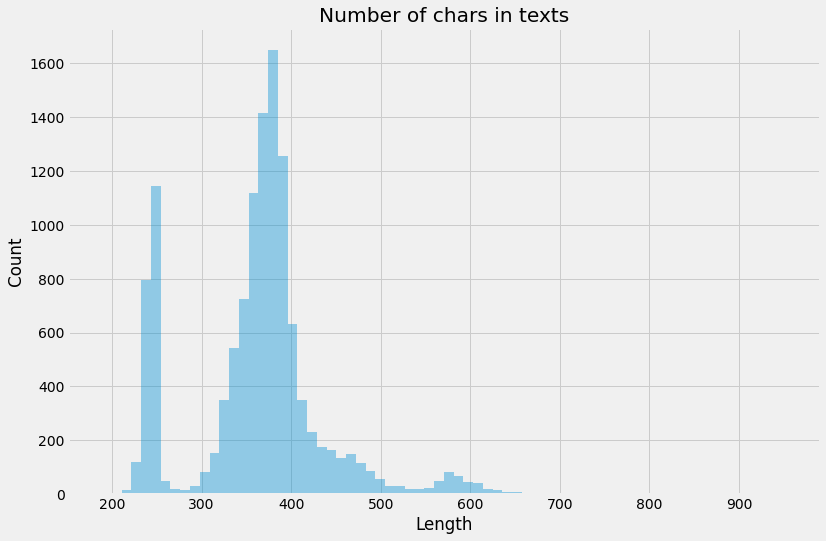

In [127]:
plot_hist(df.chars_num, bins=70,
          title='Number of chars in texts',
          xlabel='Length',
          ylabel='Count')

In [128]:
df['chars_num'].quantile([0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])

0.100    245.00
0.300    347.00
0.500    370.00
0.600    379.00
0.700    387.00
0.800    398.00
0.900    438.00
0.950    485.00
0.990    600.50
0.999    686.75
Name: chars_num, dtype: float64

### Words in text

In [129]:
# simple word tokenize
df['words_num'] = df['text'].apply(lambda x: len(x.split()))

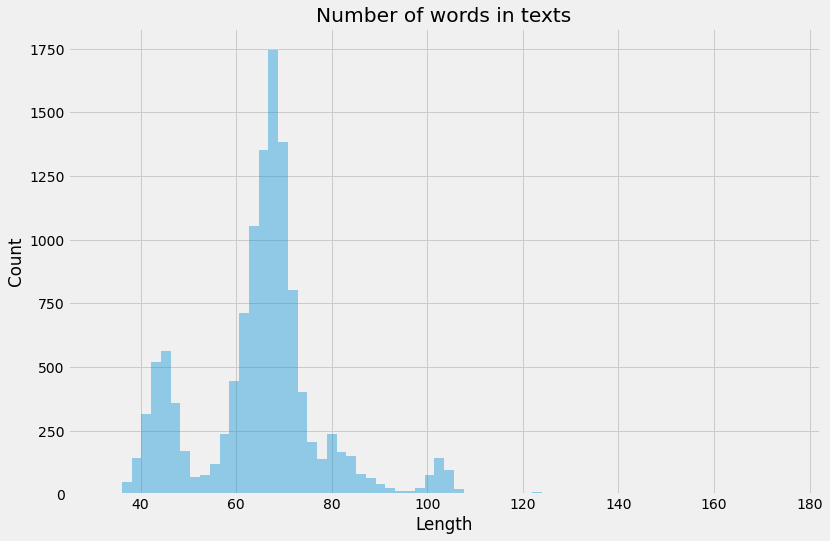

In [130]:
plot_hist(df.words_num, bins=70,
          title='Number of words in texts',
          xlabel='Length',
          ylabel='Count')

In [131]:
df['words_num'].quantile([0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])

0.100     45.0
0.300     62.0
0.500     66.0
0.600     68.0
0.700     69.0
0.800     71.0
0.900     78.0
0.950     86.0
0.990    104.0
0.999    123.0
Name: words_num, dtype: float64

### Number of words per category

In [155]:
df_group = df.groupby(by='category', as_index=False).words_num.agg(['sum', 'count'])

In [159]:
df_group['words_avg'] = df_group['sum'] / df_group['count']

In [160]:
df_group

,sum,count,words_avg
category,,,
birthday,37991,366,103.800546
career,96309,2159,44.608152
general,289558,4391,65.943521
love,272178,4081,66.693948
wellness,87098,1054,82.635674


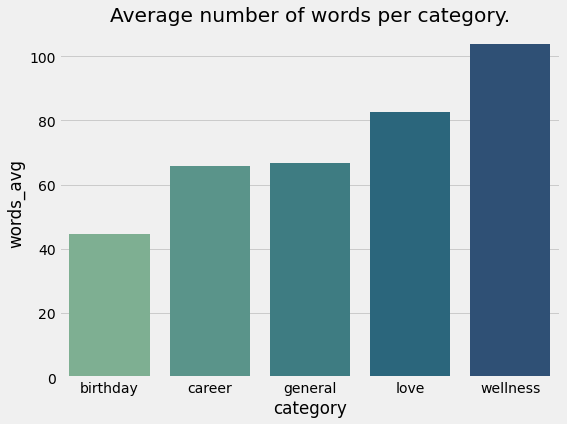

In [163]:
plt.figure(figsize=(8,6))
sns.barplot(x=df_group.index, y='words_avg', data=df_group.sort_values(by='words_avg'), palette='crest')
plt.title("Average number of words per category.")
plt.show();

### Find texts that include special characters

In [164]:
def is_printable(string):
    for s in string:
        if s not in printable:
            return 0
    return 1

In [165]:
df['is_text_printable'] = df['text'].apply(lambda x: is_printable(x))

In [166]:
df[df.is_text_printable == 0].shape

(144, 7)

In [167]:
df[df.is_text_printable == 0]['text'].sample(5).values

array(["Today you might crave the companionship of friends and lovers alike, Sagittarius. You're probably in the mood for some good food, good music, and great conversation, and that's just what you'll get if it’s possible in any way. Later you might spend time alone with a love partner, reflecting on recent conversations. Some of them might be worthy of deeper thought. Have a pleasant day and a wonderful evening.",
       "Today's planetary alignment is there to encourage you in your pursuit of truth. This is like the Hollywood starlet carrying out the director's wishes with perfection and grace, creating something sublime. In other words, act out your fantasies! Remember that in order to do this successfully, you must plan. A great thing to plan is the meals you will eat in a week. Plan all of them (or up to 5 days’ worth) at the start of each week. You will reap enormous benefits: physically, emotionally and financially.",
       "Today's aspect at play brings with it a chance to do

- Single apostrophes in texts `’` seem to be of a different font than regular one `'`. Should replace them.

- Similarly, replace `–` with `-`. Minute difference.

- Replace `“”` with `"`

- Replace `…` with `.`

- The rest include characters like `ê, ç`. Deciding to keep them.

In [168]:
is_printable('“')

0

### Most Frequent Words per each Category

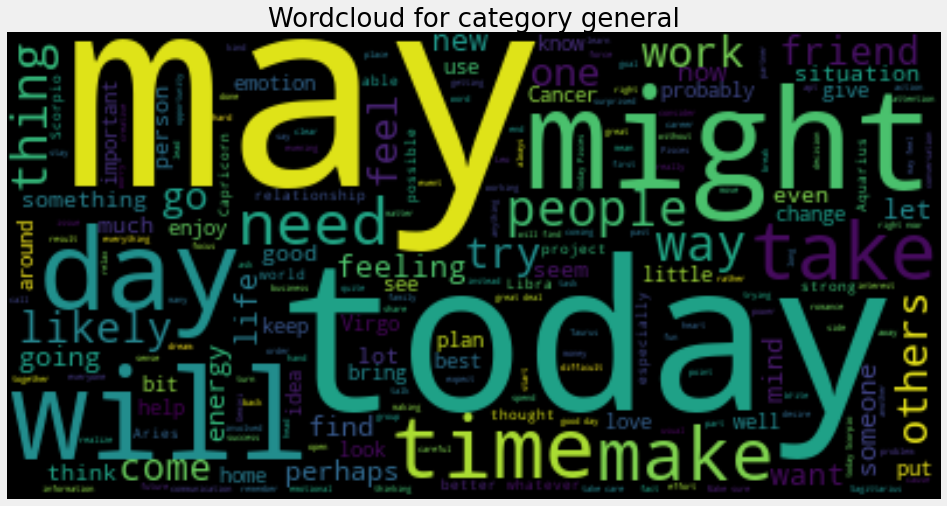

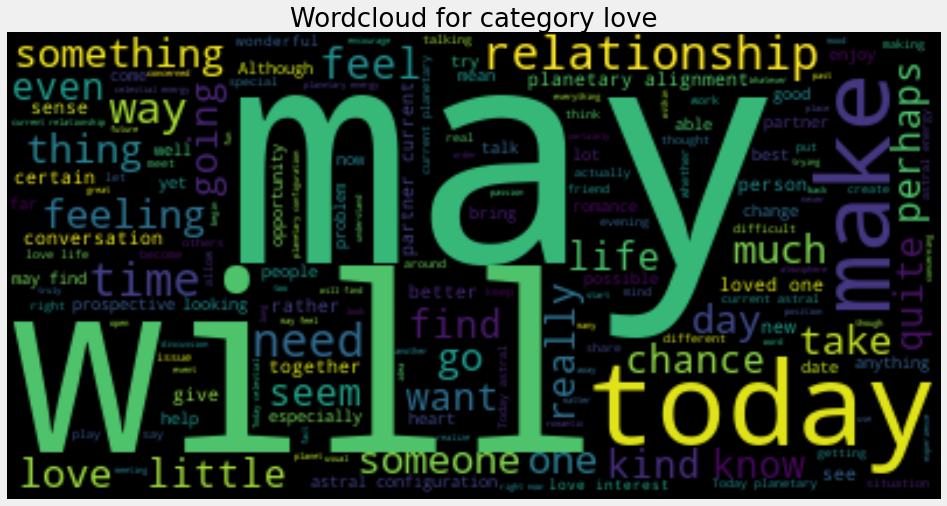

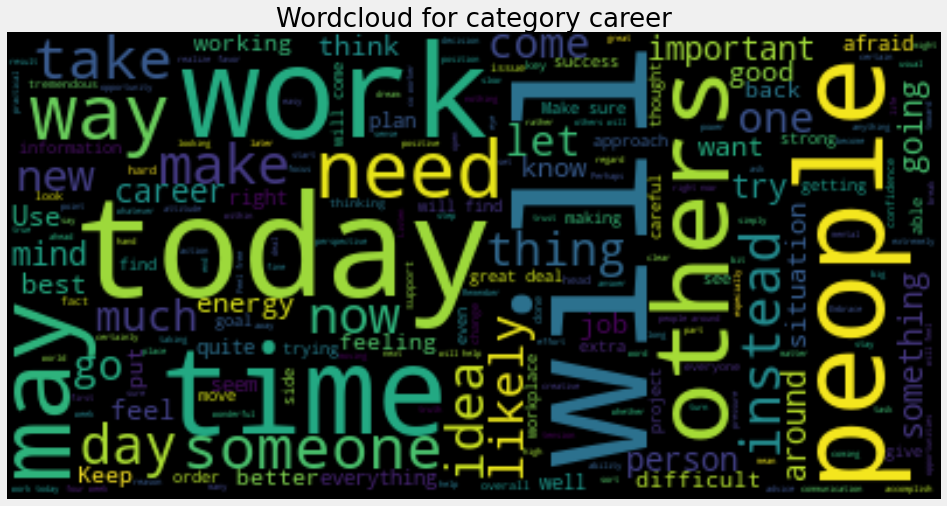

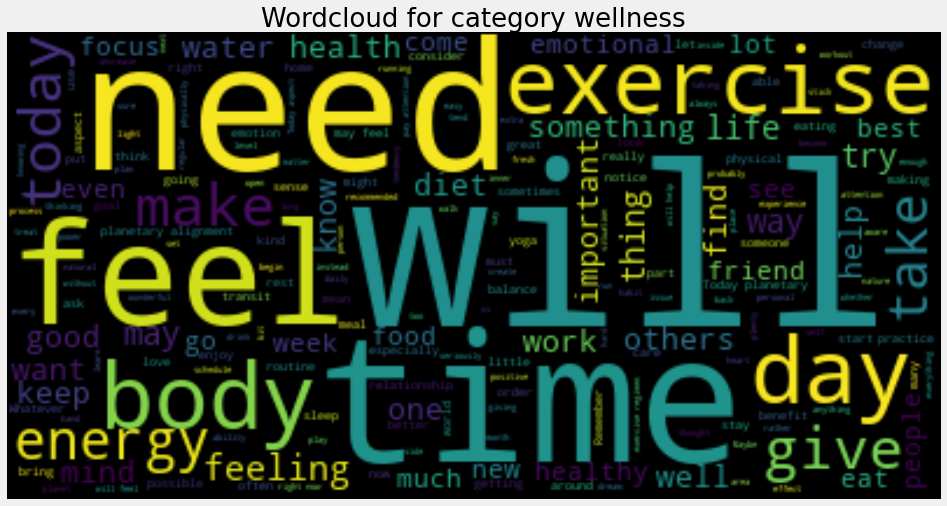

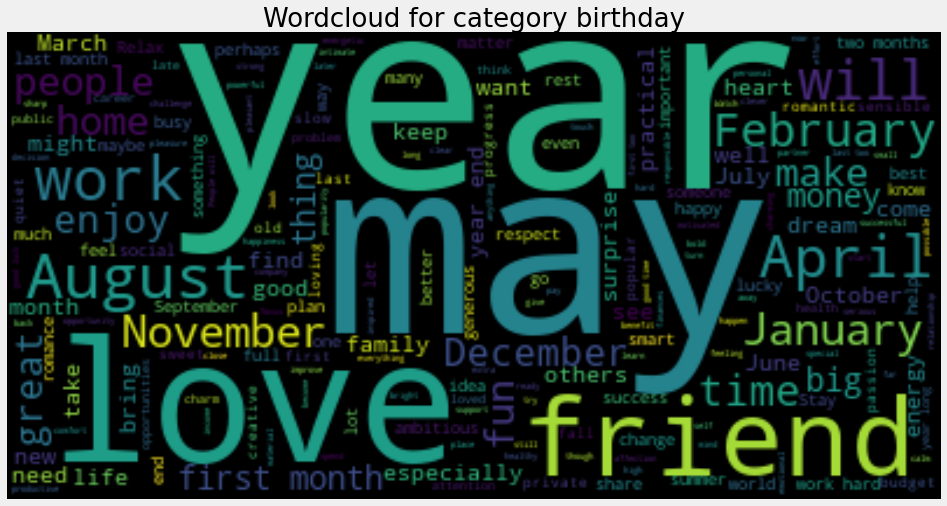

In [169]:
for cat in df['category'].value_counts().index:
    text = ' '.join(df[df['category'] == cat]['text'].values)
    
    wordcloud = WordCloud(stopwords=set(STOPWORDS)).generate(text)
    
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud for category {cat}', fontsize=26)

### Do texts have any emojis? 

*Possibly not, but just checking.*

In [170]:
def has_emoji(text):
    emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
    
    if emoji_pattern.search(text):
        return 1
    return 0

In [171]:
df['has_emoji'] = df.text.apply(lambda x: has_emoji(x))

In [172]:
df[df.has_emoji == 1]

,sign,category,date,text,chars_num,words_num,is_text_printable,has_emoji


### Do texts have any double or more spaces?

In [173]:
def has_multiple_spaces(text):
    spaces_pattern = re.compile(r"\s\s+")
    
    if spaces_pattern.search(text):
        return 1
    return 0

In [174]:
df['has_multiple_spaces'] = df.text.apply(lambda x: has_multiple_spaces(x))

In [175]:
df[df.has_multiple_spaces == 1]

,sign,category,date,text,chars_num,words_num,is_text_printable,has_emoji,has_multiple_spaces


## Loss

In [3]:
df_loss = pd.read_pickle('../model/training_stats.pkl')

In [4]:
df_loss

[{'epoch': 1,
  'Training loss': 3.4864840705310347,
  'Validation loss': 3.036304473876953},
 {'epoch': 2,
  'Training loss': 2.9254508092340115,
  'Validation loss': 2.689502716064453},
 {'epoch': 3,
  'Training loss': 2.712897396896441,
  'Validation loss': 3.057957172393799},
 {'epoch': 4,
  'Training loss': 2.458603716529576,
  'Validation loss': 2.213318109512329},
 {'epoch': 5,
  'Training loss': 2.1669746599542004,
  'Validation loss': 2.47379732131958}]